# Convolutional Seq2Seq
In this approach, we are using Convolutional Neural Networks(CNNs) and Residual Networks in the likes of Resnet model from Microsoft.<br>
Here, we use the sequence to sequence modelling approach to predict the future translations of the English language to German language.<br>

Since, we already know CNNs are very good at extracting features from an image, so here we try to use it's feature extraction on the text data.<br>

We use, 1x3 filters(tri-gram) or kernels to get extract features over text. This kernel size helps in convolving all the text completely without any redundancy, since it can ignore the sos and eos of the input text.<br>





![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq0.png)

# Introduction

In this notebook, we'll be building a machine learning model to go from once sequence to another, using PyTorch and TorchText. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization, i.e. going from a sequence to a shorter sequence in the same language.

Before we delve deep into the code, lets first understand the model architecture as mentioned in the paper.

Lets recall our general RNN based encoder decoder model, 

<!-- ![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

In the general case, we use our encoder (teal block), basically a RNN layer over the embedded source sequence to create context. All the encoded states from the encoder along with the context go to the attention block, this attention block predicts sort of number called alpha which indicates the amplitude of all the encoded states going forward. Attention places different focus on different words by assigning each word with a alpha score. We then use that context vector with the decoder (blue block), we also pass a vector representation (attention vector) from every encoder time step to the decoder. This helps the network to focus on right word of the input sequence so that it can make appropriate translations to predict the next words of the target sequence -->

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

We use our encoder (green) over the embedded source sequence (yellow) to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

# How convolutional sequence to sequence model work?

An architecture proposed by authors for sequence to sequence
modeling is entirely convolutional.
Below diagram outlines the structure of convolutional sequence to sequence model.
![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq0.png)

Like any RNN based sequence to sequence structure CNN based model uses encoder decoder architecture, however here both encoder and decoder are composed of stacked convolutional layers with a special type of activation function called Gated Linear Units. In the middle there is a attention function. The encoder extracts features from the source sequence, while decoder learns to estimate the function that maps the encoders hidden state and its previous generated words to the next word. The attention tells the decoder which hidden states of the encoder to focus on. 

A concept of **positional embedding**, is been introduced in this model. Well, what do we mean by positional embedding?

In CNN, we process all the words in a sequence simultaneously, it is impossible to capture the sequence order information like we do in RNNs (a timeseries based model). In order to use the sequence information of the sequence, the absolute position information of the tokens needs to be injected into the model and we need to explicity sent this information to the network.  This works just like a regular word embedding but instead of mapping words, it maps the absolute position of a word to a dense vector. The position embeding output will be added on the word embeding. With this additional information, the model knows which part of the context it is handling.


<!-- RNN which is a timeseries based model, we send and process the words sequentially. However, in CNN we need to send all the words simultaneously. The problem with this is the network will not know the order / location / position of the sequence word being sent. -->


![positional emd.PNG](https://drive.google.com/uc?export=view&id=1UHgIGYWVin23pHKw8TiU7WlLL3vOZ_r8)

The paper also applies residual connection between the blocks in both the encoder and the decoder, which allows for deeper convolutional network. 

### Why residual connection?

Models with many layers often rely on shortcut or residual connections. When we stack up convolutional layers to form a deeper model, it becomes harder and harder to optimize since the model has a lot of parameters, resulting in poor performance and also the gradient values start exploding and becomes very difficult to handle. This is solved by adding a residual block (skip connections) i.e to add the previous blocks output onto the current block directly. This technique makes the learning process easier and faster, enabling the model to go deeper, also helps improve the accuracy.


<!-- Instead of trying to approximate the direct mapping function H(x) from the input to the output, we estimate the residual mapping function F(x), which is essentially H(x) - input of the current block. We can think of F(x) is modifying x to approximate H(x), instead of learning a whole new mapping function.  -->





In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 1.2MB 27.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


## Import Modules

First, we'll import all the modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Next, we'll set the random seed for reproducability. Till the kernel is alive, the seed is a valid. If we shutdown the kernel the seed will be reset, next time when the kernel is restart we will not be able to reproduce same result.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 12.1MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=25b8a8c8b3a301942c7beb6c83ddc1f687d66097728aeee9f57bd41c8ec4a100
  Stored in directory: /tmp/pip-ephem-wheel-cache-bf8x3diz/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word.

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

Note: the models must first be downloaded using the following on the command line:

    python -m spacy download en
    python -m spacy download de

We load the models as below:

In [5]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [6]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

TorchText's Fields handle how data should be processed.

We set the tokenize argument to the correct tokenization function for each, with German being the SRC (source) field and English being the TRG (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the init_token and eos_token arguments, and converts all words to lowercase.

RNN Models by default expects the sequence to be of shape [sequence length, batch size] so TorchText will return batches of tensors in the same shape. Since we are using CNNs,  they expect batch_size to be first, so we set batch_first=True so that TorchText can return the tensors of dimension [batch size, sequence length].

In [7]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Next, we download and load the train, validation and test data.

The dataset we'll be using is the Multi30k dataset. This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), 
                                                    fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 950kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 271kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 268kB/s]


Then create our vocabulary, converting all tokens appearing less than twice into tokens.

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

We also need to define a torch.device. This is used to tell TorchText to put the tensors on the GPU or not. We use the torch.cuda.is_available() function, which will return True if a GPU is detected on our computer. 

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a src attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a trg attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

When we get a batch of examples using an iterator, we use a BucketIterator instead of the standard Iterator as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.


In [11]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Encoder

Let's now have a closer look at the Encoder structure.

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq1.png)

- We take the German sentence add padding at the start <sos> and end of the sentence <eos> and split those into tokens. This is because, the CNN layer is going to reduce the length of the sentence, to maintain same sentence length we add padding.
- We first send it to the embeding layer to get the word embedding, we also need to encode the position of the word, so we will be literally sending the position(index postion of the words) to another similar embeding layer to get the positional embeddings. 
- We then do a element wise sum of word embedding and postional embedding, that is going to result in a combined embedding which is a element wise vector (This layer knowns the word and also has encoded even the location of the word) .
- This vector goes into a Fully connected layer because we need to convert it into a particular dimention and also, to help increase capacity and extract information, basically to convert these simple numbers into something which is more complex (like rearranging of features).
- The ouput of each of these FC layer is simultaneously sent to the multiple convolution blocks.
- For each of the information that is going into the convolutional block, we are going to get individual outputs.
- This output is again sent to another fully connected layer, because the output of the convolution need to be converted into the embedding dimension of the encoder.
- The final vector will have the embedding equal to the number of dimension we want.
- We also add a skip connection the output of the final FC layer gets added with the element wise sum of word and position embeding , i.e we are sending the whole word along with the position of the word to the decoder as convolutional layer might loose the positional information.

Finally, from the encoder block we will be sending two outputs to the decoder, one is the conved output and another is combined vector (which is combination of transformed vector and embedding vector)
i.e suppose we have 6 tokens, we will be getting 12 context vectors, 2 context vectors per token, one from conved and another from combined. 



## Convolutional Blocks

Lets now see the convolutional block within encoder architecture

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq2.png)


- As mentioned earlier we pass the padded input sentence to the CNN block, this is because the CNN layer is going to reduce the length of the sentence, and we need to ensure that the length of the input sentence getting into the convolution block is equal to the length of the sentence going out of the convolution block.
- We will be then convolving the padded output using a kernel size of 3 (odd size)
- The output of this is sent to a special kind of acivation GLU (Gated Linear Unit) activation.

    ### How GLU activation works?
    The output of convolutional layer i.e input to GLU is split into two halves A and B, half the input (A) would go to sigmoid and we would then do a element wise sum of both. Sigmoid acts as a gate, determining which part of B are relevant to the current context. The larger the values of entry in A the more important that corresponding entry in B is. The gating mechanisn of the models enables to select the effective parts of the input features in preducting the next words. Since the GLU is going to reduce the input to half, we would be doubling the input to the convolution block.

    ![GLU.PNG](https://drive.google.com/uc?export=view&id=1Uu_ZOvkISyBdB517Ik-FFNebBJeVWItQ)

- Then we add a residual connection i.e The output of the combined vector is going to be added as a skip connection to the output of the GLU, this done just to avoid any issues associated with the convolutional layers, this skip connections ensures smooth flow of gradients

This concludes a single convolutional block. Subsequent blocks take the output of the previous block and perform the same steps. Each block has their own parameters, they are not shared between blocks. The output of the last block goes back to the main encoder - where it is fed through a linear layer to get the conved output and then elementwise summed with the embedding of the token to get the combined output.





In [12]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        #call embedding layers
        self.tok_embedding = nn.Embedding(input_dim, emb_dim) #input dim and emd dim
        self.pos_embedding = nn.Embedding(max_length, emb_dim) # this needs to know max length (as we can't handle every lenth of the sequence, we need to have a stop)

        #add linear layer to the output of the embedding
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, #how many input channels - hid_dim
                                              out_channels = 2 * hid_dim, # how many output channels - 
                                              kernel_size = kernel_size, # kernel size 3x1
                                              padding = (kernel_size - 1) // 2) # padding enabled
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        # we need to repeat this because we need the position for all the sentence in the batch, so repeat at batch_size at the distribution of 1
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) 
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1) # specifies the dimension in which we are going to divide the GLU

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            # whenever we add two number, we double the amplitude this will cause sudden increase in the overall gradients required
            # so whenever we add vextores we need to scale them, else the numbers can explode and BP may suffer
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

## Decoder 

The Decoder is very similar to Encoder, but with few changes.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq3.png)

- We will passing the whole output for the prediction, like encoder we will first pass the tokens to the embeding layer to get the word and postional embedding.
- Add both the word and postional embedding using element wise sum, pass it to the fully connected layer, which then goes to the convolutional layer.
- The convolutional layer accepts two additional inputs i.e the encoder conved and encoder combined (this is to feed encoder information into the decoder), we also pass the embedding vector as a residual connection to the convolution layer. Unlike the encoder, the resnet connection or skip connection goes only to the convolution block it doesnot go to the output of the convolution block because we have to use the information to predict the output.
- This goes to two layer linear network (FC layer) to make the final prediction.



## Decoder Conv Blocks

Let's now see the decoder convolutional blocks, this is similar to the one within encoder. However there are few changes.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq4.png)

For encoder the input sequence is padded so that the input and output lengths are the same and we would pad the target sentence in the decoder aswell for the same reason. However, for decoder we only pad at the beginning of the sentence, the padding makes sure the target of the decoder is shifted by one word from its input. Since we are processing all the target sequence simultaneously, so we need a method of not only allowing the filter to translate the token that we have to the next stage, but we also need to make sure that the model will not learn to output the next word in the sequence by directly copying the next word, without actually learning how to translate. 

<!-- the attension in the middle can be computed simultaneously for the length of the kernel (queries) to parallelize the training process. However, during testing we need to wait for the next word to be generated in order to proceed to the next time step -->

If we don't pad it at the beginning (as shown below), then the model will see the next word while convolving and would literally be copying that to the output, without learning to translate

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq5.png)


## Attention

The model also adds a attention in every decoder layer and demonstrate that each attention layer only adds a negligible amount of overhead.The model uses both encoder conved and encoder combined, to figure out where exactly the encoder want the model to focus on while making the prediction
- Firstly, we take the conved output of a word from the decoder, do a element wise sum with the decoder input embedding to generate combined embedding
- Next, we calculate the attention between the above generated combined embedding and the encoder conved, to find how much it matches with the encoded conved 
- Then, this is used to calculate the weighted sum over the encoded combined to apply the attention.
- This is then projected back up to the hidden dimenson size and a residual connection to the initial input is applied to the attention layer.

This can be seen as attention with multiple ’hops’ compared to single step attention

In [13]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

# Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will stitch the Encoder and Decoder together:

- Firstly <eos> token is sliced off from the target sentence as we do not input this token to the decoder.
- The encoder receives the input/source sentence and produces two context vectors for each word:
  - encoder_conved (output from final encoder conv. block) and 
  - encoder_combined [encoder_conved plus (elementwise) src embedding plus positional embeddings]
- The decoder takes in all the target sentence at one to produce the prediction of output/target sentence

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of prediced) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

# Training the Seq2Seq Model
Now we have our model implemented, we can begin training it.

First, we'll initialize our model, we define all of the hyperparameters, initialize the encoder and decoder, and initialize the overall model - placing it on the GPU if we have one.

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

We also define a function that will calculate the number of trainable parameters in the model.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,685 trainable parameters


We define our optimizer, which we use to update our parameters in the training loop.

Next, we define our loss function. The CrossEntropyLoss function calculates both the log softmax as well as the negative log-likelihood of our predictions.

Our loss function calculates the average loss per token, however by passing the index of the <pad> token as the ignore_index argument we ignore the loss whenever the target token is a padding token.

In [17]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training loop.

First, we'll set the model into "training mode" with model.train(). This will turn on dropout and then iterate through our data iterator.

Consider we have a target sequence, trg, of something like [\<sos>, s1, s2, s3, \<eos>]. We want our decoder to predict what the next item in the predicted target sequence should be, given the previously predicted target tokens. So, we input a sequence of [\<sos>, s1, s2, s3] by slicing of \<eos> token (which is trg[:,:-1]) and want our decoder to predict [s1, s2, s3, <eos>] (which is trg[:,1:]).

Thus, we input trg[:,:-1] and use the predicted target with trg[:,1:] to calculate our losses.



In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with model.eval(). This will turn off dropout.

We use the with torch.no_grad() block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called state_dict in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [21]:
N_EPOCHS = 10
CLIP = 0.01

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 14s
	Train Loss: 4.209 | Train PPL:  67.299
	 Val. Loss: 3.017 |  Val. PPL:  20.431
Epoch: 02 | Time: 1m 15s
	Train Loss: 3.035 | Train PPL:  20.792
	 Val. Loss: 2.388 |  Val. PPL:  10.893
Epoch: 03 | Time: 1m 15s
	Train Loss: 2.609 | Train PPL:  13.583
	 Val. Loss: 2.132 |  Val. PPL:   8.433
Epoch: 04 | Time: 1m 15s
	Train Loss: 2.376 | Train PPL:  10.761
	 Val. Loss: 2.004 |  Val. PPL:   7.415
Epoch: 05 | Time: 1m 15s
	Train Loss: 2.217 | Train PPL:   9.175
	 Val. Loss: 1.911 |  Val. PPL:   6.758
Epoch: 06 | Time: 1m 15s
	Train Loss: 2.096 | Train PPL:   8.137
	 Val. Loss: 1.859 |  Val. PPL:   6.416
Epoch: 07 | Time: 1m 15s
	Train Loss: 2.015 | Train PPL:   7.502
	 Val. Loss: 1.810 |  Val. PPL:   6.111
Epoch: 08 | Time: 1m 15s
	Train Loss: 1.937 | Train PPL:   6.938
	 Val. Loss: 1.784 |  Val. PPL:   5.952
Epoch: 09 | Time: 1m 15s
	Train Loss: 1.877 | Train PPL:   6.533
	 Val. Loss: 1.769 |  Val. PPL:   5.863
Epoch: 10 | Time: 1m 15s
	Train Loss: 1.819 | Train PPL

We'll load the parameters (state_dict) that gave our model the best validation loss and run it the model on the test set.

In [22]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.798 | Test PPL:   6.035 |


# Inference

Now we can use our trained model to generate translations. Following are the steps that we taken during inference:
- Firstly, ensure our model is in evaluation mode, which it should "always" be for inference
- When a new unseen sentence is passed, we first convert that to lower case and tokenize the sentence
- append the \<sos> and \<eos> tokens
- map the tokens to their indexes i.e corresponding integer representation fron vocab
- convert it to a tensor and use unsqueeze operation to add a batch dimension
- feed the source sentence into the encoder using torch.no_grad() block to ensure no gradients are calculated within the block to reduce memory consumption and speed things up.
- create a list to hold the output sentence, initialized with an \<sos> token
- while we have not hit a maximum length
    - convert the current output sentence prediction into a tensor with a batch dimension
    - place the current output and the two encoder outputs into the decoder
    - get next output token prediction from decoder
    - add prediction to current output sentence prediction
    - break if the prediction was an <eos> token
- convert the output sentence from indexes to tokens
- return the output sentence (with the <sos> token removed) and the attention from the last layer

In [23]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention


Next, we'll make a function that displays the model's attention over the source sentence for each input during each decoder step.

In [24]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# Predictions

In [25]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [26]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'climbing', 'in', 'a', 'playhouse', 'made', 'of', 'wood', '.', '<eos>']


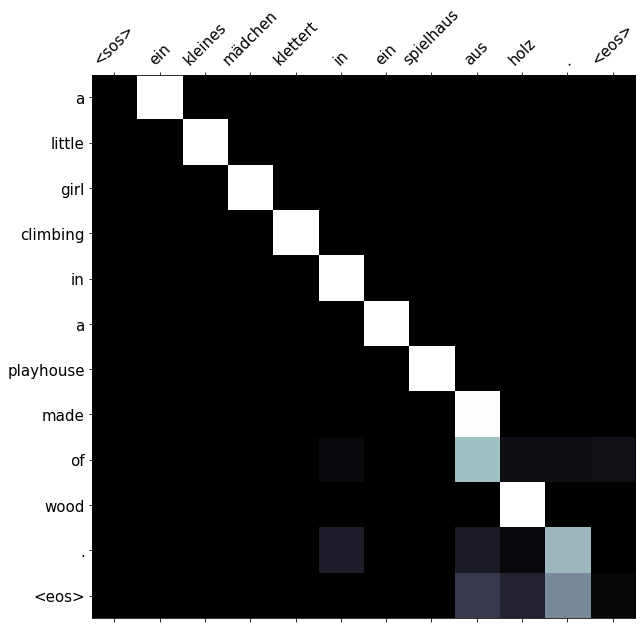

In [27]:
display_attention(src, translation, attention)

In [28]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [29]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'with', 'headphones', 'sits', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<eos>']


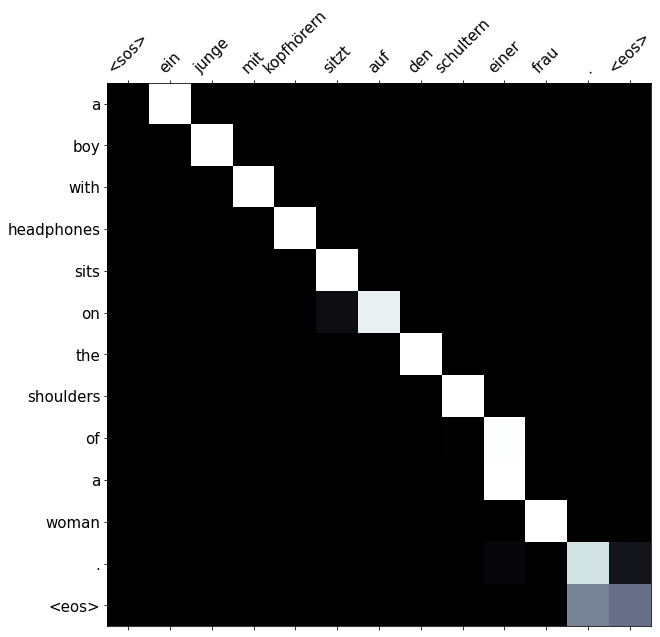

In [30]:
display_attention(src, translation, attention)

In [31]:
example_idx = 9

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'einer', 'weste', 'sitzt', 'auf', 'einem', 'stuhl', 'und', 'hält', 'magazine', '.']
trg = ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'in', 'a', 'chair', 'and', 'holding', 'magazines', '.']


In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'on', 'a', 'chair', 'holding', 'a', '<unk>', '.', '<eos>']


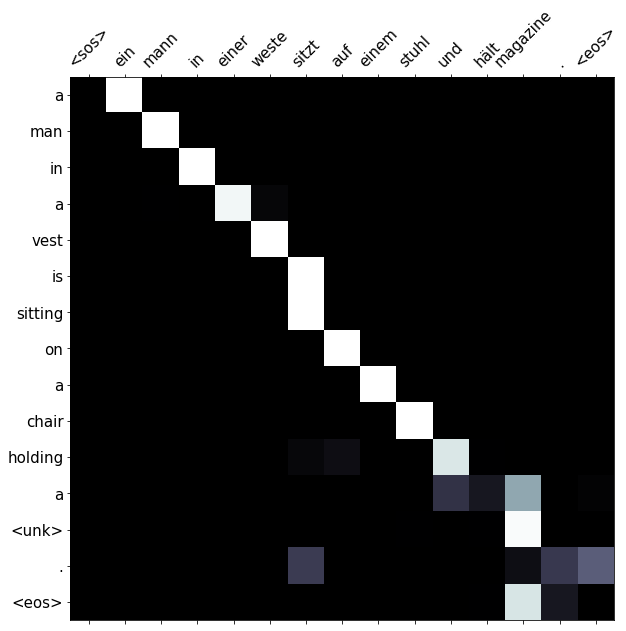

In [33]:
display_attention(src, translation, attention)

# BLEU Score

The Bilingual Evaluation Understudy Score, or BLEU for short is a method for automatic evaluation of machine translation. BLEU is a score for comparing/evaluating a candidate translation (translated sentence) of text to one or more reference translation (ground truth). 
It is based on "text string matches" i.e it quantifies how good a machine translation by computing a similarity score based on ngram precision.

BLEU score can also be used to evalutate a wide range of text generation NLP tasks like language generation, image caption generation, text summarization etc.

Few benefits of BLEU score:
  - Quick and inexpensive to calculate
  - easy to understand
  - language independent


BLEU metrics ranges from 0 to 1. The higher the BLEU Score the better.



In [34]:

from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [35]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.41


# Conclusion

Compared to RNN models convolution models have two advantages. 
- First, it runs faster because convolution can be performed in parallel. By contrast, RNN needs to wait for the value of the previous timesteps to be computed.
- Second, it captures dependencies of different lengths between the words easily. In a group of stacked CNN layers, the bottom layers captures closer dependencies while the top layers extract longer (complex) dependencies  between words.

Having said that when comparing RNN vs CNN, both are commonplace in the field of Deep Learning. Each architecture has advantages and disadvantages that are dependent upon the type of data that is being modeled.

***From the abstract of the paper, the authors claim to outperform the accuracy of deep LSTMs in WMT’14 English-German and WMT’14 English-French translation at an order of magnitude faster speed, both on GPU and CPU*.**
